In [1]:
import pandas as pd
import numpy as np
import os
import re
from collections import defaultdict

In [2]:
log_folder = 'logs/minute_training_log/snp_with_look_back_only_10_predicts_2/'

def agg_by_threshold(thresholds):
    files = sorted(os.listdir(log_folder))
    print(files)
    by_threshold = []
    for threshold in thresholds:
        by_threshold += [[file for file in files if threshold in file.split('_')[-1]]]
    return by_threshold

In [3]:
def create_key(original_line):
    result = []
    of_interest = ['block_depth', 
                   'const_factor', 
                   'learning_rate', 
                   'linear_dim', 
                   'percentile',
                  ]
    for item in of_interest:
        pattern = re.compile(item+'=[\d.]*')
        result += [re.search(pattern, original_line).group(0)]
    return ','.join(result)

In [4]:
def process_single_log_file(file_path):
    split_colon = lambda x: x.split(':')

    test_data = (pd.read_csv(file_path)
                   .iloc[:-1, 2:]
                   .iloc[1::2]
                   .iloc[:, 1:9]
                   .applymap(split_colon))
    
    if test_data.empty:
        return None
    
    names = (test_data.applymap(lambda x: x[0])
                      .iloc[0]
                      .values
                      .tolist())
    names = list(map(lambda x: x.replace(' ', ''), names))
    dataframe = (test_data.iloc[:, :-1].applymap(lambda x: float(x[-1]))
                          .copy())
    confusion_matrix_ = test_data.iloc[:, -1].map(lambda x: x[-1]).copy()
    dataframe = pd.concat((dataframe, confusion_matrix_), axis=1)
    dataframe.columns = names
    
    return dataframe

In [5]:
def get_key_and_df(file_name):
    file_path = log_folder + file_name

    with open(file_path, 'r') as f:
        line = f.readlines()[0]
        key = create_key(line)
    
    df = process_single_log_file(file_path)
    
    if df is None:
        return None, None
    else:
        return key, df 

In [6]:
def get_relevant_key_df(file_name):
    key, df = get_key_and_df(file_name)
    if df is None:
        return None, None
    
    relevant_df = df[(df.F1Score > 0.00001)
#                      & (df.index < 60)
#                      & (df.BCE <= df.BCE.quantile(0.3))
                    ].copy()
#     return key, df

    if len(relevant_df) > 0:
        return key, relevant_df
    else:
        return None, None

In [7]:
def garner_relevant_dictionary():
    
    thresholds = ['0.1', '0.2', '0.3', '0.35', '0.65', '0.7', '0.8', '0.9']
    files_by_thresholds = agg_by_threshold(thresholds)

    # Not sure if this should be default_dict
    so_far = defaultdict(list)
    for files in files_by_thresholds:
        for file in files:
            key, df = get_relevant_key_df(file)
            if key is not None:
                so_far[key].append(df)
    
    return so_far

In [8]:
my_dict = garner_relevant_dictionary()
# iter_my_dict = iter(my_dict.items())

['training_bce_2019-01-16_16:40:21_0.15.log', 'training_bce_2019-01-16_17:23:39_0.2.log', 'training_bce_2019-01-16_18:13:21_0.8.log', 'training_bce_2019-01-17_13:24:49_0.15.log', 'training_bce_2019-01-17_14:32:23_0.2.log', 'training_bce_2019-01-17_15:45:17_0.8.log', 'training_bce_2019-01-18_13:59:38_0.15.log', 'training_bce_2019-01-18_14:04:54_0.15.log', 'training_bce_2019-01-18_14:05:40_0.15.log', 'training_bce_2019-01-18_15:00:34_0.2.log', 'training_bce_2019-01-18_19:32:50_0.15.log', 'training_bce_2019-01-18_20:17:13_0.2.log', 'training_bce_2019-01-18_20:51:06_0.8.log', 'training_bce_2019-01-18_21:28:58_0.85.log', 'training_bce_2019-01-18_22:47:27_0.15.log', 'training_bce_2019-01-18_23:23:48_0.2.log', 'training_bce_2019-01-19_00:50:13_0.8.log', 'training_bce_2019-01-19_01:27:00_0.85.log', 'training_bce_2019-01-19_02:23:17_0.15.log', 'training_bce_2019-01-19_02:58:05_0.2.log', 'training_bce_2019-01-19_15:13:06_0.15.log', 'training_bce_2019-01-19_15:57:48_0.2.log', 'training_bce_2019-0

In [35]:
training_results = []
pct = 0.8
statement = 'percentile={}'.format(pct)
for key, df in my_dict.items():
    if statement in key : # and 'block_depth=3' in key:
        if len(df) > 1:
            print('key {} has length: {} > 1'.format(key, len(df)))
        training_results.append((key, df[0]))

In [36]:
# training_results_sorted = sorted(training_results, 
#                                  key=lambda x: (x[1].Mean*x[1].F1Score).mean(), 
#                                  reverse=True)
reverse = pct > 0.5

training_results_sorted = sorted(training_results, 
                                 key=lambda x: (x[1].Mean).mean(), 
                                 reverse=reverse)

In [37]:
for key, result in training_results_sorted:
    print(key)

block_depth=6,const_factor=4,learning_rate=0.007,linear_dim=3,percentile=0.8
block_depth=5,const_factor=6,learning_rate=0.008,linear_dim=3,percentile=0.85
block_depth=5,const_factor=6,learning_rate=0.008,linear_dim=5,percentile=0.85
block_depth=5,const_factor=4,learning_rate=0.008,linear_dim=5,percentile=0.85
block_depth=5,const_factor=4,learning_rate=0.008,linear_dim=4,percentile=0.85
block_depth=4,const_factor=4,learning_rate=0.01,linear_dim=3,percentile=0.8
block_depth=4,const_factor=4,learning_rate=0.01,linear_dim=3,percentile=0.85
block_depth=5,const_factor=6,learning_rate=0.008,linear_dim=5,percentile=0.8
block_depth=5,const_factor=4,learning_rate=0.008,linear_dim=3,percentile=0.85
block_depth=5,const_factor=4,learning_rate=0.008,linear_dim=3,percentile=0.8
block_depth=3,const_factor=4,learning_rate=0.007,linear_dim=3,percentile=0.8
block_depth=5,const_factor=6,learning_rate=0.008,linear_dim=4,percentile=0.8
block_depth=5,const_factor=6,learning_rate=0.008,linear_dim=4,percentile

In [38]:
print('F1Score, Mean, Precision, Stdev, Count')
for key, result in training_results_sorted:
    print('{:.5f}, {:.5f}, {:.5f}, {:.5f}, {}'.format(
          result.F1Score.mean(), 
          result.Mean.mean(),
          result.Precision.mean(), 
          result.Stdev.mean(),
          result.Mean.count(),)
         )

F1Score, Mean, Precision, Stdev, Count
0.00159, 0.00045, 0.36258, 0.00238, 30
0.00098, 0.00040, 0.30993, 0.00281, 48
0.00051, 0.00035, 0.28258, 0.00238, 32
0.00066, 0.00032, 0.30979, 0.00223, 29
0.00142, 0.00026, 0.30500, 0.00172, 49
0.00045, 0.00024, 0.38003, 0.00141, 15
0.00078, 0.00020, 0.26543, 0.00213, 70
0.00127, 0.00020, 0.35773, 0.00239, 43
0.00042, 0.00012, 0.32097, 0.00162, 21
0.00040, 0.00010, 0.37838, 0.00227, 24
0.00040, 0.00009, 0.36028, 0.00144, 15
0.00055, 0.00009, 0.33201, 0.00171, 42
0.00046, 0.00009, 0.27791, 0.00151, 24
0.00049, 0.00003, 0.34256, 0.00176, 21
0.00045, 0.00002, 0.23660, 0.00320, 38
0.00031, 0.00002, 0.32168, 0.00164, 17
0.00079, -0.00001, 0.30343, 0.00711, 46
0.00100, -0.00008, 0.34983, 0.00543, 43
0.00049, -0.00010, 0.31841, 0.00287, 16
0.00072, -0.00010, 0.32613, 0.00743, 26
0.00093, -0.00013, 0.32137, 0.00597, 47
0.00056, -0.00018, 0.32265, 0.00828, 38
0.00042, -0.00040, 0.29679, 0.00949, 25


In [39]:
import matplotlib.pyplot as plt

In [41]:
ranks = 1
print(training_results_sorted[ranks][0])

training_results_sorted[ranks][1]
# training_results_sorted[ranks][1].BCE.plot()

block_depth=5,const_factor=6,learning_rate=0.008,linear_dim=3,percentile=0.85


,BCE,F1Score,ROC_AUC,Precision,Recall,Mean,Stdev,ConfusionMatrix
51,0.43984,0.00006,0.54550,0.21429,0.00003,-0.00031,0.00114,[1579409 33 302989 9]
55,0.43933,0.00013,0.55094,0.28986,0.00007,0.00071,0.00613,[1579393 49 302978 20]
59,0.43841,0.00012,0.56316,0.29032,0.00006,0.00019,0.00154,[1579398 44 302980 18]
61,0.43709,0.00017,0.56996,0.31707,0.00009,0.00075,0.00505,[1579386 56 302972 26]
63,0.43663,0.00021,0.57453,0.30476,0.00011,0.00062,0.00501,[1579369 73 302966 32]
65,0.43930,0.00090,0.57112,0.29122,0.00045,0.00033,0.00337,[1579111 331 302862 136]
67,0.43586,0.00063,0.58008,0.30159,0.00031,0.00031,0.00357,[1579222 220 302903 95]
69,0.44977,0.00016,0.57638,0.30000,0.00008,0.00014,0.00127,[1579386 56 302974 24]
71,0.44381,0.00094,0.58188,0.31849,0.00047,0.00032,0.00277,[1579136 306 302855 143]
73,0.43842,0.00015,0.57804,0.30556,0.00007,0.00090,0.00577,[1579392 50 302976 22]


block_depth=5,const_factor=6,learning_rate=0.008,linear_dim=3,percentile=0.85


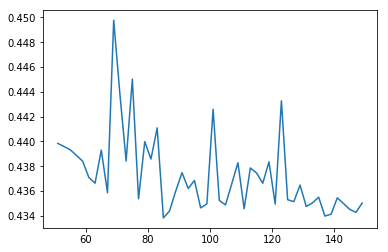

In [42]:
print(training_results_sorted[ranks][0])

# training_results_sorted[ranks][1]
training_results_sorted[ranks][1].BCE.plot()